In [20]:
from sklearn.datasets import load_iris
import paddle 
import numpy as np

def load_data(shuffle=True):
    X = np.array(load_iris().data, dtype=np.float32)
    y = np.array(load_iris().target, dtype=np.float32)

    X = paddle.to_tensor(X)
    y = paddle.to_tensor(y)

    X_min = paddle.min(X, axis=0)
    X_max = paddle.max(X, axis=0)
    X = (X-X_min) / (X_max-X_min)

    if shuffle:
        idx = paddle.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]
    return X, y

In [21]:
class IrisDataset(paddle.io.Dataset):
    def __init__(self, mode="train", num_train=120, num_dev=15):
        super(IrisDataset, self).__init__()
        X, y =load_data(shuffle=True)
        y = paddle.cast(y, dtype='int32')
        if mode == "train":
            self.X, self.y = X[:num_train], y[:num_train]
        elif mode == "dev":
            self.X, self.y = X[num_train:num_train+num_dev], y[num_train:num_train+num_dev]
        else:
            self.X, self.y = X[num_train+num_dev:], y[num_train+num_dev:]

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

In [22]:
paddle.seed(12)
train_dataset = IrisDataset(mode="train")
dev_dataset = IrisDataset(mode="dev")
test_dataset = IrisDataset(mode="test")

In [23]:
print("length of train set:", len(train_dataset))
print("length of dev set:", len(dev_dataset))
print("length of test set:", len(train_dataset))

length of train set: 120
length of dev set: 15
length of test set: 120


In [24]:
batch_size = 16 

train_loader = paddle.io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = paddle.io.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = paddle.io.DataLoader(test_dataset, batch_size=batch_size)

In [25]:
import paddle.nn as nn 
import paddle.nn.functional as F 
from paddle.nn.initializer import Constant, Normal, Uniform 

class Model_MLP_L2_V3(nn.Layer):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_MLP_L2_V3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, weight_attr=paddle.ParamAttr(initializer=Normal(mean=0., std=0.01)),
        bias_attr=paddle.ParamAttr(initializer=Constant(value=1.0)))
        self.fc2= nn.Linear(hidden_size, output_size, weight_attr=paddle.ParamAttr(initializer=Normal(mean=0., std=0.01)),
        bias_attr=paddle.ParamAttr(initializer=Constant(value=1.0)))
        self.act_fn = F.sigmoid

    def forward(self, inputs):
        outputs = self.fc1(inputs)
        outputs = self.act_fn(outputs)
        outputs = self.fc2(outputs)
        return outputs

fnn_model = Model_MLP_L2_V3(input_size=4, output_size=3, hidden_size=6)

In [45]:
from paddle.metric import Metric 

class Accuracy(Metric):
    def __init__(self, is_logist=True):
        self.num_correct = 0
        self.num_count = 0
        self.is_logist = is_logist

    def update(self, outputs, labels):
        if outputs.shape[1] == 1:
            outputs = paddle.squeeze(outputs, axis=-1)
            if self.is_logist:
                preds = paddle.cast((outputs>=0), dtype='int32')
            else:
                preds = paddle.cast((outputs>=0.5), dtype='int32')
        else:
            preds = paddle.argmax(outputs, axis=1, dtype='int32')
        labels = paddle.squeeze(labels, axis=-1)
        batch_correct = paddle.sum(paddle.cast(preds==labels, dtype='int32')).numpy().item()
        batch_count = len(labels)
        self.num_correct += batch_correct
        self.num_count += batch_count

    def accumulate(self):
        if self.num_count == 0:
            return 0
        return self.num_correct/ self.num_count

    def reset(self):
        self.num_correct = 0
        self.num_count = 0

    def name(self):
        return "Accuracy"

In [27]:
import paddle.nn.functional as F

class RunnerV3(object):
    def __init__(self, model, optimizer, loss_fn, metric, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric # 只用于计算评价指标

        # 记录训练过程中的评价指标变化情况
        self.dev_scores = []

        # 记录训练过程中的损失函数变化情况
        self.train_epoch_losses = [] # 一个epoch记录一次loss
        self.train_step_losses = []  # 一个step记录一次loss
        self.dev_losses = []
        
        # 记录全局最优指标
        self.best_score = 0

    def train(self, train_loader, dev_loader=None, **kwargs):
        # 将模型切换为训练模式
        self.model.train()

        # 传入训练轮数，如果没有传入值则默认为0
        num_epochs = kwargs.get("num_epochs", 0)
        # 传入log打印频率，如果没有传入值则默认为100
        log_steps = kwargs.get("log_steps", 100)
        # 评价频率
        eval_steps = kwargs.get("eval_steps", 0)

        # 传入模型保存路径，如果没有传入值则默认为"best_model.pdparams"
        save_path = kwargs.get("save_path", "best_model.pdparams")

        custom_print_log = kwargs.get("custom_print_log", None) 
       
        # 训练总的步数
        num_training_steps = num_epochs * len(train_loader)

        if eval_steps:
            if self.metric is None:
                raise RuntimeError('Error: Metric can not be None!')
            if dev_loader is None:
                raise RuntimeError('Error: dev_loader can not be None!')
            
        # 运行的step数目
        global_step = 0

        # 进行num_epochs轮训练
        for epoch in range(num_epochs):
            # 用于统计训练集的损失
            total_loss = 0
            for step, data in enumerate(train_loader):
                X, y = data
                # 获取模型预测
                logits = self.model(X)
                loss = self.loss_fn(logits, y) # 默认求mean
                total_loss += loss 

                # 训练过程中，每个step的loss进行保存
                self.train_step_losses.append((global_step,loss.item()))

                if log_steps and global_step%log_steps==0:
                    print(f"[Train] epoch: {epoch}/{num_epochs}, step: {global_step}/{num_training_steps}, loss: {loss.item():.5f}")
                
                # 梯度反向传播，计算每个参数的梯度值
                loss.backward() 

                if custom_print_log:
                   custom_print_log(self)
                
                # 小批量梯度下降进行参数更新
                self.optimizer.step()
                # 梯度归零
                self.optimizer.clear_grad()

                # 判断是否需要评价
                if eval_steps>0 and global_step>0 and \
                    (global_step%eval_steps == 0 or global_step==(num_training_steps-1)):

                    dev_score, dev_loss = self.evaluate(dev_loader, global_step=global_step)
                    print(f"[Evaluate]  dev score: {dev_score:.5f}, dev loss: {dev_loss:.5f}") 

                    # 将模型切换为训练模式
                    self.model.train()

                    # 如果当前指标为最优指标，保存该模型
                    if dev_score > self.best_score:
                        self.save_model(save_path)
                        print(f"[Evaluate] best accuracy performence has been updated: {self.best_score:.5f} --> {dev_score:.5f}")
                        self.best_score = dev_score

                global_step += 1
            
            # 当前epoch 训练loss累计值 
            trn_loss = (total_loss / len(train_loader)).item()
            # epoch粒度的训练loss保存
            self.train_epoch_losses.append(trn_loss)
            
        print("[Train] Training done!")

    # 模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def evaluate(self, dev_loader, **kwargs):
        assert self.metric is not None

        # 将模型设置为评估模式
        self.model.eval()

        global_step = kwargs.get("global_step", -1) 

        # 用于统计训练集的损失
        total_loss = 0

        # 重置评价
        self.metric.reset() 
        
        # 遍历验证集每个批次    
        for batch_id, data in enumerate(dev_loader):
            X, y = data
    
            # 计算模型输出
            logits = self.model(X)
            
            # 计算损失函数
            loss = self.loss_fn(logits, y).item()
            # 累积损失
            total_loss += loss 

            # 累积评价
            self.metric.update(logits, y)

        dev_loss = (total_loss/len(dev_loader))
        dev_score = self.metric.accumulate() 

        # 记录验证集loss
        if global_step!=-1:
            self.dev_losses.append((global_step, dev_loss))
            self.dev_scores.append(dev_score)
        
        return dev_score, dev_loss
    
    # 模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def predict(self, x, **kwargs):
        # 将模型设置为评估模式
        self.model.eval()
        # 运行模型前向计算，得到预测值
        logits = self.model(x)
        return logits

    def save_model(self, save_path):
        paddle.save(self.model.state_dict(), save_path)

    def load_model(self, model_path):
        model_state_dict = paddle.load(model_path)
        self.model.set_state_dict(model_state_dict)

In [46]:
import paddle.optimizer as opt 

model = fnn_model 
optimizer = opt.SGD(learning_rate=0.2, parameters=model.parameters())
loss_fn = F.cross_entropy
metric = Accuracy(is_logist=True)
runner = RunnerV3(model, optimizer, loss_fn, metric)

In [47]:
# 启动训练
log_steps = 100
eval_steps = 50
runner.train(train_loader, dev_loader, 
            num_epochs=150, log_steps=log_steps, eval_steps = eval_steps,
            save_path="best_model.pdparams") 

[Train] epoch: 0/150, step: 0/1200, loss: 1.05428
[Evaluate]  dev score: 0.40000, dev loss: 1.02602
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.40000
[Train] epoch: 12/150, step: 100/1200, loss: 0.92708
[Evaluate]  dev score: 0.73333, dev loss: 0.91046
[Evaluate] best accuracy performence has been updated: 0.40000 --> 0.73333
[Evaluate]  dev score: 0.86667, dev loss: 0.75469
[Evaluate] best accuracy performence has been updated: 0.73333 --> 0.86667
[Train] epoch: 25/150, step: 200/1200, loss: 0.69224
[Evaluate]  dev score: 0.93333, dev loss: 0.62163
[Evaluate] best accuracy performence has been updated: 0.86667 --> 0.93333
[Evaluate]  dev score: 0.66667, dev loss: 0.57165
[Train] epoch: 37/150, step: 300/1200, loss: 0.55916
[Evaluate]  dev score: 0.93333, dev loss: 0.48467
[Evaluate]  dev score: 0.93333, dev loss: 0.44786
[Train] epoch: 50/150, step: 400/1200, loss: 0.53597
[Evaluate]  dev score: 0.86667, dev loss: 0.41609
[Evaluate]  dev score: 1.00000, dev lo

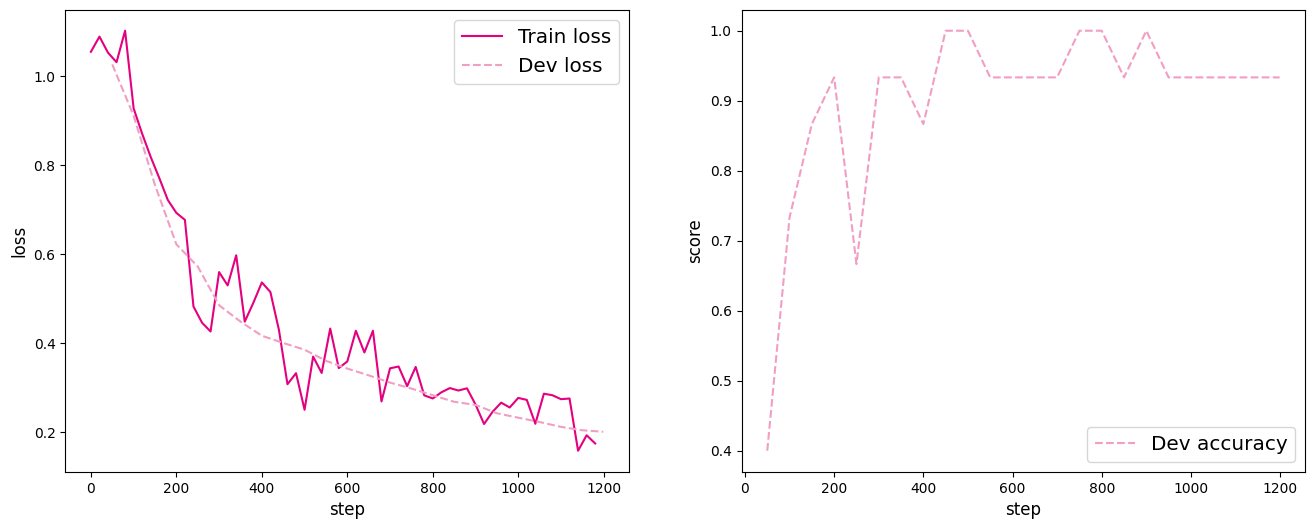

In [48]:
import matplotlib.pyplot as plt

# 绘制训练集和验证集的损失变化以及验证集上的准确率变化曲线
def plot_training_loss_acc(runner, fig_name, 
    fig_size=(16, 6), 
    sample_step=20, 
    loss_legend_loc="upper right", 
    acc_legend_loc="lower right",
    train_color="#e4007f",
    dev_color='#f19ec2',
    fontsize='large',
    train_linestyle="-",
    dev_linestyle='--'):

    plt.figure(figsize=fig_size)

    plt.subplot(1,2,1)
    train_items = runner.train_step_losses[::sample_step]
    train_steps=[x[0] for x in train_items]
    train_losses = [x[1] for x in train_items]

    plt.plot(train_steps, train_losses, color=train_color, linestyle=train_linestyle, label="Train loss")
    if len(runner.dev_losses)>0:
        dev_steps=[x[0] for x in runner.dev_losses]
        dev_losses = [x[1] for x in runner.dev_losses]
        plt.plot(dev_steps, dev_losses, color=dev_color, linestyle=dev_linestyle, label="Dev loss")
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize=fontsize)
    plt.xlabel("step", fontsize=fontsize)
    plt.legend(loc=loss_legend_loc, fontsize='x-large')

    # 绘制评价准确率变化曲线
    if len(runner.dev_scores)>0:
        plt.subplot(1,2,2)
        plt.plot(dev_steps, runner.dev_scores,
            color=dev_color, linestyle=dev_linestyle, label="Dev accuracy")
    
        # 绘制坐标轴和图例
        plt.ylabel("score", fontsize=fontsize)
        plt.xlabel("step", fontsize=fontsize)
        plt.legend(loc=acc_legend_loc, fontsize='x-large')

    plt.savefig(fig_name)
    plt.show()

plot_training_loss_acc(runner, 'fw-loss.pdf')

In [49]:
# 加载最优模型
runner.load_model('best_model.pdparams')
# 模型评价
score, loss = runner.evaluate(test_loader)
print("[Test] accuracy/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] accuracy/loss: 0.9333/0.4830


In [52]:
# 获取测试集中第一条数据
X, label = next(test_loader())
logits = runner.predict(X)

pred_class = paddle.argmax(logits[0]).numpy()
label = label[0].numpy()

# 输出真实类别与预测类别
print("The true category is {} and the predicted category is {}".format(label, pred_class))

The true category is 0 and the predicted category is 0
